In [46]:
import numpy as np
from numpy import sqrt, exp, array, arange
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import norm
from scipy.interpolate import CubicSpline

import sympy
sympy.init_printing

def display_matrix(m):
    display(sympy.Matrix(m))

In [42]:
# Black-Scholes analytical pricing formula for european options
def blackScholesPricer(S, K, r, sigma, T, type="call"):
    """
    S       : stock price
    K       : strike price
    r       : risk-free interest rate
    sigma   : volatility
    T       : time to expiry
    """

    assert type in ["call", "put"]

    d_1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d_2 = (np.log(S / K) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

    if type == "call":
        option_price = S * norm.cdf(d_1) - K * exp(-r * T) * norm.cdf(d_2)
    elif type == "put":
        option_price = K * exp(-r * T) * norm.cdf(-d_2) - S * norm.cdf(-d_1)

    return option_price

In [47]:
# use finite differences to solve the Black-Scholes PDE to obtain option price

def finiteDifferencesPricer(K, r, sigma, q, S_max, M, T, N):
    """
    K : strike price
    r : risk-free interest rate
    sigma : volatility
    S_max: maximum stock price
    T : total time until maturity (in years)
    q : continuous dividend yield
    N : number of grid-points in time
    M : number of grid-points in stock price
    """

    deltaT = T / N
    deltaS = S_max / M
    grid = np.zeros((M+1, N+1)) # grid is (M + 1) x (N + 1)

    zero_S_bc = K # boundary condition when stock price is zero
    large_S_bc = 0 # boundary condition when stock price = S_max

    # boundary conditions of a put
    grid[-1, :] = zero_S_bc  # S = 0
    grid[0, :] = large_S_bc  # S -> infty
    # need to reverse the array because index increases from bottom to top
    # initial condition at maturity: t = T
    grid[:, -1] = np.maximum(K - arange(0, M+1) * deltaS, 0)[::-1]

    # coefficients
    a_vec = 0.5 * (r - q) * arange(1, M) * deltaT - 0.5 * (sigma ** 2) * (arange(1, M) ** 2) * deltaT
    b_vec = 1 + r * deltaT + (sigma ** 2) * (arange(1, M) ** 2) * deltaT
    c_vec = -0.5 * (r - q) * arange(1, M) * deltaT - 0.5 * (sigma ** 2) * (arange(1, M) ** 2) * deltaT

    # offset due to boundary conditions
    offset = np.zeros(M-1)
    offset[0] = a_vec[0] * zero_S_bc
    offset[-1] = c_vec[-1] * large_S_bc

    # need to solve a sparse linear system for each iteration
    tri = csc_matrix(np.diag(a_vec[1:], k=-1) + np.diag(b_vec, k=0) + np.diag(c_vec[:-1], k=1))

    # backwards iteration
    for i in range(N-1, -1, -1):
        forward = grid[1:M, i+1]
        prices_at_iteration = spsolve(tri, forward[::-1] - offset)
        grid[1:M, i] = prices_at_iteration[::-1]

    # interpolate to get the option price at a specific initial stock price
    cs = CubicSpline(arange(0, S_max + deltaS, deltaS), grid[:, 0])

    # grid = np.matrix.round(grid, decimals=2); display_matrix(grid)
    # plt.plot(np.arange(0, S_max + deltaS, deltaS), grid[:, 0])
    # plt.plot(np.arange(0, S_max + deltaS, deltaS), np.arange(0, S_max + deltaS, deltaS) - K * exp(-r * T))

    return

finiteDifferencesPricer(50, 0.10, 0.40, 0, 100, 20, 0.4163, 10)

In [43]:
# Binomial tree pricer
def binomialPricer(S, K, r, sigma, T, q, n, type="call", style="european"):
    """
    S       : initial stock price
    K       : strike price
    r       : risk-free interest rate
    sigma   : volatility
    T       : time to expiry
    q       : continuous dividend yield
    n       : size of tree
    """

    assert type in ["call", "put"]
    assert style in ["american", "european"]

    # Useful quantities to define
    t = T / n
    u = exp(sigma * sqrt(t))
    d = exp(-sigma * sqrt(t))
    a = exp((r-q) * t)
    p = (a - d) / (u - d)

    price_tree = []
    for i in range(0, n+1):
        node_list = np.zeros((i+1,2)) # left to right encodes lowest to highest
        for j in range(0, i+1):
            # each node is [stock price, option price]: option price is zero-initialized
            node_list[j, 0] = S * (u ** j) * (d ** (i-j))
        price_tree.append(node_list)

    # calculate option prices at expiration date
    for j in range(0, n+1):
        S_nj = price_tree[-1][j, 0]

        if type == "call":
            price_tree[-1][j, 1] = max(S_nj - K, 0)
        elif type == "put":
            price_tree[-1][j, 1] = max(K - S_nj, 0) 

    # update option prices but moving backwards through the tree
    for i in range(n-1, -1, -1):
        for j in range(0, i+1):

            # discounted expected value
            binomial_price = exp(-r * t) * (p * price_tree[i+1][j+1, 1] + (1-p) * price_tree[i+1][j, 1])

            S_ij = price_tree[i][j, 0]
            if type == "call":
                exercise_price = max(S_ij - K, 0)
            elif type == "put":
                exercise_price = max(K - S_ij, 0) 
            
            if style == "american":
                price_tree[i][j, 1] = max(binomial_price, exercise_price)
            elif style == "european":
                price_tree[i][j, 1] = binomial_price

    # for i in range(0, n+1):
    #     print(price_tree[i])

    return price_tree[0][0, 1]


In [ ]:
# use Monte Carlo methods for pricing the option

def monteCarloPricer(K, r, sigma, q):

    # sample a path for S(t) in a risk neutral world
    # calculate the payoff from the derivative
    # repeat steps 1 and 2
    # calculate the mean of sample payoffs to get estimate of the expected payoff
    # discount expected payoff at the risk free rate

    

    return

monteCarloPricer()

In [41]:
# check that it agrees with example 21.1 in Options, Futures, and other Derivatives by John Hull
print("The price of the 5-month American put is:", binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0,
                                                                  n=30, type="put", style="american"))

option_prices = []
for N in [30, 50, 100, 500]:
    p = binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0,
                       n=N, type="put", style="american")
    option_prices.append(np.around(p, 3))
print(f"The prices found should be {option_prices} == [4.264, 4.272, 4.278, 4.283] to agree with Hull.")

print("The price of a 5-month American call is:", binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0, 
                                                                 n=300, type="call", style="european"))

# check that the pricing of European options obeys put-call parity (approximately?)
p = binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0, n=300, type="put", style="european")
c = binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0, n=300, type="call", style="european")
print("The price of the 5-month European put is:", p)
print("The price of the 5-month European call is:", c)
print("LHS of put-call parity:", c + 50 * exp(-0.10 * 0.4167))
print("RHS of put-call parity:", p + 50)

# check the lower bound on the price of a call option: c >= S - Ke^{-rT}
# by making S >> K (so that it is almost certainly exercised)
c = binomialPricer(S=1000, K=50, r=0.10, sigma=0.40, T=0.4167, q=0, n=300, type="call", style="european")
print("The price of the 5-month European call is:", c)
print("The lower bound on a European call is:", 1000 - 50 * exp(-0.10 * 0.4167))

The price of the 5-month American put is: 4.26356525884711
The prices found should be [4.264, 4.272, 4.278, 4.283] == [4.264, 4.272, 4.278, 4.283] to agree with Hull.
The price of a 5-month American call is: 6.1125445804183824
The price of the 5-month European put is: 4.0718575712322105
The price of the 5-month European call is: 6.1125445804183824
LHS of put-call parity: 54.071857571232215
RHS of put-call parity: 54.07185757123221
The price of the 5-month European call is: 952.0406870091853
The lower bound on a European call is: 952.0406870091862


In [44]:
# compare the binomial and black-scholes pricer

bsm_price = blackScholesPricer(S=100, K=95, r=0.01, sigma=0.50, T=0.25, type="call")
bin_price = binomialPricer(S=100, K=95, r=0.01, sigma=0.50, T=0.25, q=0,
                           n=2000, type="call", style="european")

print("The Black-Scholes-Merton price is:", bsm_price)
print("The binomial tree price is:", bin_price)

The Black-Scholes-Merton price is: 12.527923392521458
The binomial tree price is: 12.529007625809305


In [6]:
option_prices = []
for N in range(2, 100):
    option_prices.append(binomialPricer(50, 50, 0.10, 0.40, 0.4167, 0, N, type="put", style="american"))

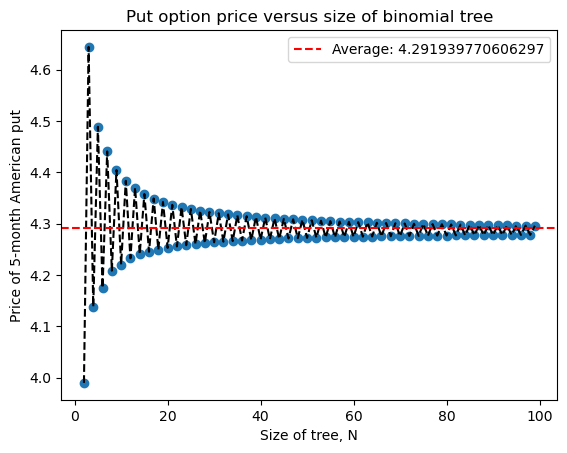

In [7]:
plt.scatter(range(2, 100), option_prices)
plt.plot(range(2, 100), option_prices, linestyle="--", color="black")
plt.xlabel("Size of tree, N")
plt.ylabel("Price of 5-month American put")
plt.axhline(np.average(option_prices), label=f"Average: {np.average(option_prices)}", color="red", linestyle="--")
plt.title("Put option price versus size of binomial tree")
plt.legend()